<a href="https://colab.research.google.com/github/chandank21/Dragon_Real_State-Price-Prediction-ML-Model/blob/main/Clustering_of_Electrical_Load_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path =  '/content/drive/MyDrive/datasets/household_power_consumption.txt'
cols_to_use = ['Date', 'Time','Global_active_power']

df_uci = pd.read_csv(data_path, sep=';', usecols=cols_to_use)

In [10]:
df_uci.head()

,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [5]:
df_uci['datetime'] = pd.to_datetime(df_uci['Date'] + ' '+ df_uci['Time'])

In [6]:
df_uci = df_uci.drop(['Date','Time'], axis=1)
df_uci = df_uci.set_index('datetime')

In [ ]:
import numpy as np
df_uci = df_uci.replace('?', np.nan)
df_uci = df_uci.astype(np.float).fillna(method='bfill')

In [12]:
# For simplication,
# I will resample so that each row
# represents a whole hour
df_uci_hourly = df_uci.resample('H').sum()
x=df_uci.resample('H').mean()

In [15]:
df_uci_hourly

,Global_active_power,hour
2006-12-16,152.024,17
2006-12-16,217.932,18
2006-12-16,204.014,19
2006-12-16,196.114,20
2006-12-16,183.388,21
...,...,...
2010-12-11,143.518,19
2010-12-11,105.200,20
2010-12-11,66.894,21
2010-12-11,19.232,22


In [14]:
df_uci_hourly['hour'] = df_uci_hourly.index.hour
df_uci_hourly.index = df_uci_hourly.index.date

df_uci_pivot = df_uci_hourly.pivot(columns='hour')
df_uci_pivot = df_uci_pivot.dropna()

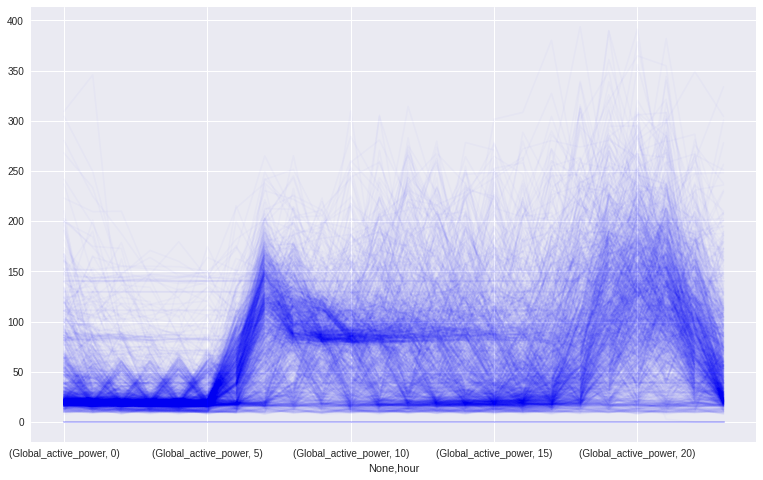

In [16]:
%matplotlib inline
plt.style.use('seaborn')
df_uci_pivot.T.plot(figsize=(13,8), legend=False, color='blue', alpha=0.02)

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

X = df_uci_pivot.values.copy()
    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append((f"cluster={n_cluster}",silhouette_score(X, kmeans.labels_)))

In [47]:
kmeans = KMeans(n_clusters=3)

In [48]:
cluster_found = kmeans.fit_predict(X)


In [49]:
cluster_found

array([0, 0, 2, ..., 1, 2, 2], dtype=int32)

In [50]:
cluster_found_sr = pd.Series(cluster_found, name='cluster')


In [ ]:
cluster_found_sr[:100]

In [ ]:
df_uci_pivot.head()

In [43]:
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr, append=True )


In [44]:
df_uci_pivot.head()

Global_active_power           ...                  
hour                                0        1   ...       22       23
           cluster                               ...                  
2006-12-17 0                   112.948  200.964  ...   91.080   26.264
2006-12-18 0                    16.582   18.798  ...  104.328   92.836
2006-12-19 2                    50.228   21.182  ...   43.200   23.022
2006-12-20 2                    27.590   15.520  ...  183.538  142.906
2006-12-21 2                    92.152   83.878  ...   16.816   16.226

[5 rows x 24 columns]

In [55]:
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

In [56]:
cluster_values

[0, 1, 2]

In [60]:
(df_uci_pivot.index.get_level_values('cluster').to_numpy()

AttributeError: ignored

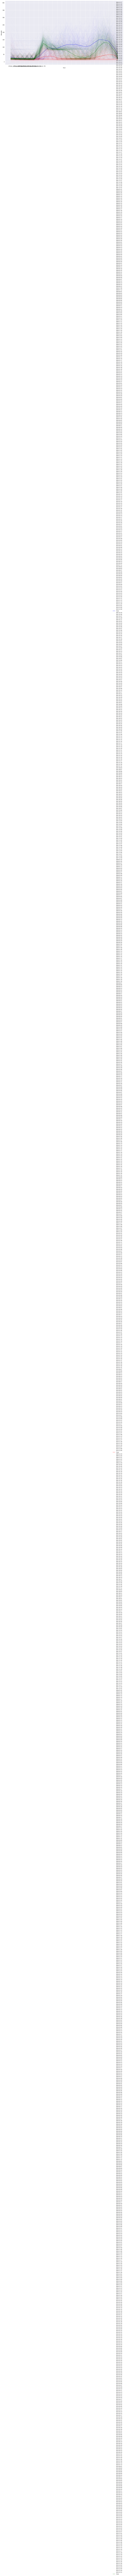

In [58]:
fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )

ax.set_xticks(np.arange(1,25))
ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
ax.legend()